In [5]:
%load_ext autoreload
%autoreload 2

In [28]:
from datasets.clock import ClockConfig
import torch
import torch.nn as nn
from vis import load_model_script, load_model_state_dict, visualize_latent, visualize_predictions, visualize_reconstruction, print_model_parameters
from train_utils.train import get_dataloaders, eval_model
from models.decoders import ResNetDecoder3

data_config = ClockConfig()

IMG_SIZE=128
BATCH_SIZE=64

dataloader, val_dataloader, _, _ = get_dataloaders(
  data_config,
  data_size=2**12,
  img_size=IMG_SIZE,
  batch_size=BATCH_SIZE,
)

LATENT_DIM=2
type_ = "decoder"
model = load_model_state_dict(
  model_class = ResNetDecoder3,
  img_size=IMG_SIZE,
  latent_dim=LATENT_DIM,
  model_args=dict(
    fc_size=1024,
    resnet_start_channels=384,
    conv_start_channels=64,
    activation='sigmoid'
  ),
  name="ResNetDecoder3",
  postfix="d22a",
  checkpoint=0
)

device = "cuda" if torch.cuda.is_available() else "cpu"

In [8]:
eval_model(type_, model, [i for i in val_dataloader], device=device, latent_dim=LATENT_DIM)

(0.017104428494349122, 0.036816144827753305)

# Encoders

In [9]:
print(model)

ResNetDecoder3(
  (fc): Sequential(
    (0): Linear(in_features=2, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=1024, bias=True)
    (4): ReLU()
    (5): Unflatten(dim=1, unflattened_size=(64, 4, 4))
  )
  (decoder_conv): Sequential(
    (0): Conv2d(64, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ConvResidualDecoderBlock(
      (upsample1): Sequential(
        (0): ConvTranspose2d(384, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
        (3): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): LeakyReLU(negative_slope=0.2)
      )
      (upsample2): Sequential(
      

In [2]:
inputs = next(iter(dataloader))
print(inputs[0].shape)

original = inputs[0]
imgs = inputs[2].to(device)

layer_outs = []

out = model.fc(imgs)
# get residual
out = model.decoder_conv[0](out)
layer_outs.append(out)
print("conv1", out.shape)
out = model.decoder_conv[1](out)
layer_outs.append(out)
print("conv2", out.shape)
out = model.decoder_conv[3](out)
layer_outs.append(out)
print("conv3", out.shape)
out = model.decoder_conv[5](out)
layer_outs.append(out)
print("conv4", out.shape)
out = model.decoder_conv[6](out)
layer_outs.append(out)
print("conv5", out.shape)


torch.Size([64, 1, 128, 128])
conv1 torch.Size([64, 384, 4, 4])
conv2 torch.Size([64, 96, 8, 8])
conv3 torch.Size([64, 24, 32, 32])
conv4 torch.Size([64, 6, 128, 128])
conv5 torch.Size([64, 1, 128, 128])


0 torch.Size([64, 384, 4, 4])
1 torch.Size([64, 96, 8, 8])
2 torch.Size([64, 24, 32, 32])
3 torch.Size([64, 6, 128, 128])
4 torch.Size([64, 1, 128, 128])


(np.float64(-0.5), np.float64(127.5), np.float64(127.5), np.float64(-0.5))

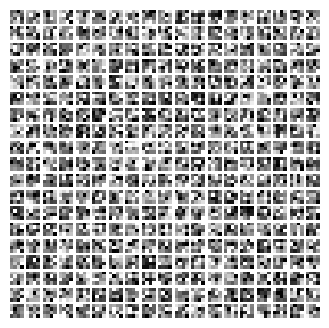

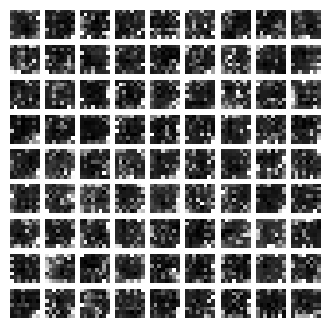

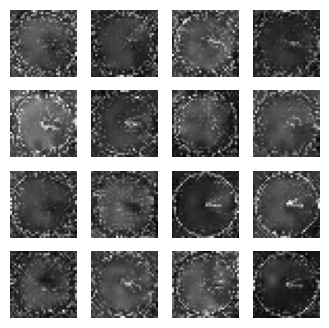

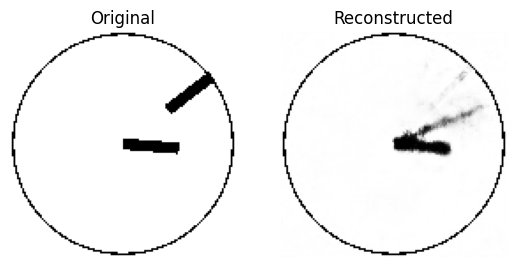

In [3]:
import matplotlib.pyplot as plt
import numpy as np

idx = np.random.randint(0, len(layer_outs)-1)
figsize=(4,4)

for i, out in enumerate(layer_outs):
  print(i, out.shape)
  if (out.shape[1] < 16):
    continue
  
  sqrt_n_channels = int(np.sqrt(out.shape[1]))
  fig, axs = plt.subplots(sqrt_n_channels, sqrt_n_channels, figsize=figsize)
  for j, ax in enumerate(axs.flatten()):
    ax.imshow(out[idx][j].detach().cpu().numpy(), cmap='gray')
    ax.axis('off')

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(original[idx].squeeze().detach().cpu().numpy(), cmap='gray')
plt.title("Original")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(model(imgs[idx].unsqueeze(0)).squeeze().detach().cpu().numpy(), cmap='gray')
plt.title("Reconstructed")
plt.axis('off')


# Autoencoders

In [35]:
# Visualize UMAP of features after fc layers
from vis import get_outputs, map_inputs
from functools import partial
import numpy as np
from umap import UMAP
import matplotlib.pyplot as plt

model = load_model_state_dict(
  model_class = ResNetDecoder3,
  img_size=IMG_SIZE,
  latent_dim=LATENT_DIM,
  model_args=dict(
    fc_size=1024,
    resnet_start_channels=384,
    conv_start_channels=64,
    activation='sigmoid'
  ),
  name="ResNetDecoder3",
  postfix="d22b",
  # checkpoint=0
)

# for ResNetDecoder
def forward(model, x):
  out = model.fc(x)
  return out

forward_fn = partial(forward, model)

data_iter = [i for i in map_inputs(type_, dataloader, forward_fn, latent_dim=LATENT_DIM)]

out = [i[3].cpu() for i in data_iter]
labels = [i[1].cpu() for i in data_iter]

X = np.array(out).reshape(len(out), -1) 
labels = np.array(labels)*(12*60)

umap = UMAP(n_neighbors=10, min_dist=0.1, n_components=2, random_state=42)
embedding = umap.fit_transform(X)

plt.figure(figsize=(8, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], s=2, c=labels, cmap='Spectral')
plt.colorbar(label='Minutes past midnight')
plt.title("UMAP of features after fc layers")
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'saved_models/ResNetDecoder3/2-i128-d22b/final.pt'

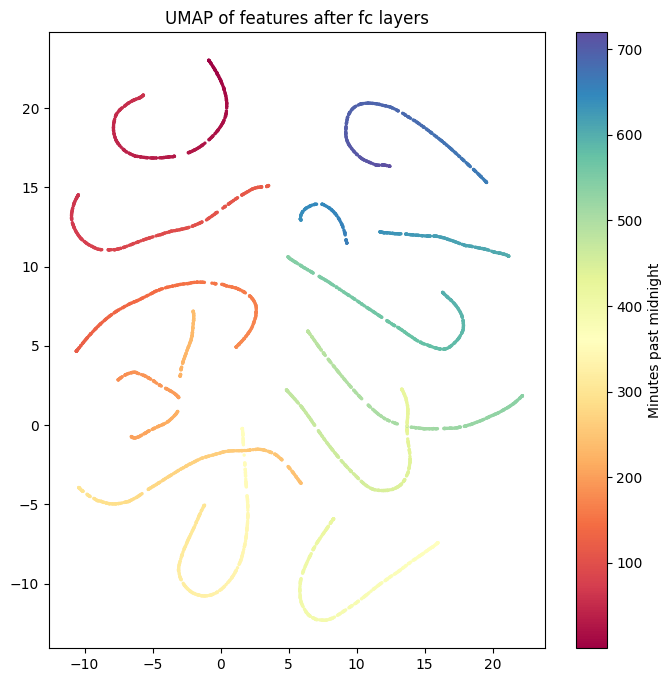

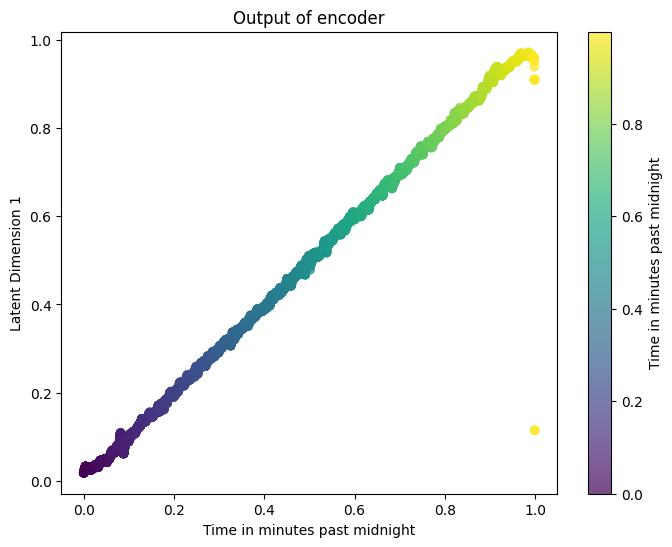

In [11]:
visualize_latent(type_, model, latent_dim=LATENT_DIM, dataloader=dataloader)